In [1]:
%matplotlib inline
import tensorflow as tf
import tensorflow_addons as tfa
from  tensorflow import keras as kr
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
from argusFuncs import *
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import pandas as pd
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.cluster import KMeans
import pickle
from numba import cuda
from sklearn.preprocessing import LabelEncoder as skLabelEncoder
from sklearn.metrics import confusion_matrix
sns.set_style('darkgrid')
sns.mpl.rc('figure',figsize=(15, 10))


Num GPUs Available:  1


In [2]:
simpleModelResultsCMsName = './images/simpleModelResultsCMs.svg'
TSNEvsUMAPImageName = './images/TSNEvsUMAP.svg'
clusteredUMAPImageName = './images/clusteredUMAP.svg'
neurNetParamCompareImageName = './images/neurNetParamCompare.svg'
ensembleDevResultsImageName = './images/ensembleDevResults.svg'
ensembleVsLogRegTestResultsImageName = './images/ensembleVsLogRegTestResults.svg'

# Create SQL Tables  
+ Load the raw data from the data source 
+ Create SQL Table of Raw Data
+ Create initial split of Train, Dev, and Test sets
+ Creat SQL Tables for each of the data splits

In [153]:
# do not run these; they will the initial data split is random, and the data will change if it is run again
# getRawInSQL()
# initialSplitSQL()

# Load the Initial Data Splits
We will load in the Train set, Dev set, and Test set

In [154]:
trainDf, devDf, testDf = loadInitialDataSplitsSQL()

# Explore Data Set
We'll make sure to work with the TRAIN set only.   

In [155]:
print("These are the columns of the data:\n{}".format(trainDf.columns.values))

These are the columns of the data:
['diagnosis' 'radius_mean' 'texture_mean' 'perimeter_mean' 'area_mean'
 'smoothness_mean' 'compactness_mean' 'concavity_mean'
 'concave_points_mean' 'symmetry_mean' 'fractal_dimension_mean'
 'radius_se' 'texture_se' 'perimeter_se' 'area_se' 'smoothness_se'
 'compactness_se' 'concavity_se' 'concave_points_se' 'symmetry_se'
 'fractal_dimension_se' 'radius_worst' 'texture_worst' 'perimeter_worst'
 'area_worst' 'smoothness_worst' 'compactness_worst' 'concavity_worst'
 'concave_points_worst' 'symmetry_worst' 'fractal_dimension_worst']


In [156]:
print("This is the shape of the data: {}".format(trainDf.shape))

This is the shape of the data: (406, 31)


In [157]:
print("These the unique values for the 'diagnosis' column:\n{}".format(trainDf['diagnosis'].unique()))

These the unique values for the 'diagnosis' column:
['M' 'B']


## summary
We have 30 variables to predict if a growth is Malignant or Benign.

# Create Simple Models
We will create:   
+ Logistic Regression Model
+ KMeans Model
+ Simple Neural Network Model

### Create a label encoder & encoded Train and Dev data sets

In [158]:
lblEnc = skLabelEncoder()
lblEnc.fit(trainDf['diagnosis'].unique())

LabelEncoder()

In [159]:
xTrain = trainDf.copy().drop(['diagnosis'], axis = 1)
yTrain = trainDf['diagnosis'].copy()
yTrain.iloc[:] = lblEnc.transform(yTrain)
xDev = devDf.copy().drop(['diagnosis'], axis = 1)
yDev = devDf.copy()['diagnosis']
yDev.iloc[:] = lblEnc.transform(yDev)

### Train Simple Logisitic Regression Model on Train Data

In [160]:
simpleLogReg = skLogReg(max_iter=3000)
simpleLogReg.fit(xTrain, yTrain)

LogisticRegression(max_iter=3000)

### Train Simple KMeans Model on Train Data

In [161]:
simpleKmeans = KMeans(n_clusters=2)
simpleKmeans.fit(xTrain, yTrain)

KMeans(n_clusters=2)

### Train Simple Neural Network on Train Data

In [1]:
simpleNeurNet = kr.Sequential([
    kr.layers.Dense(900, activation=tf.nn.swish),
    kr.layers.Dense(900, activation=tf.nn.swish),
    kr.layers.Dense(900, activation=tf.nn.swish),
    kr.layers.Dense(1, activation=tf.nn.sigmoid),
])
simpleNeurNet.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001, amsgrad=True),
              loss=kr.losses.BinaryCrossentropy(),
               metrics=['Recall', 'FalseNegatives']
              )
simpleNeurNet.fit(xTrain, yTrain, batch_size=2048, epochs=1000)

# Compare Performance of Simple Models
We will use use confusion matrices to gauge performance. 

In [163]:
# make predictions for test and dev set.
# using the simple logit model
trainPredLogReg = simpleLogReg.predict(xTrain)
devPredLogReg = simpleLogReg.predict(xDev)
# using the simple kmeans model
trainPredKmeans= simpleKmeans.predict(xTrain)
devPredKmeans = simpleKmeans.predict(xDev)
# using the simple neural net model
# because the neural net give a probablity, we will have to round the prediction
trainPredNeurNet = np.round(simpleNeurNet.predict(xTrain))
devPredNeurNet = np.round(simpleNeurNet.predict(xDev))

In [164]:
CMs = {}
# make confusion matrices 
# for simple logit model
CMs['TrainLogReg'] = confusion_matrix(trainPredLogReg, yTrain)
CMs['DevLogReg'] = confusion_matrix(devPredLogReg, yDev)
# for simple kmeans model
CMs['TrainKmeans'] = confusion_matrix(trainPredKmeans, yTrain)
CMs['DevKmeans'] = confusion_matrix(devPredKmeans, yDev)
# for simple neural net model
CMs['TrainNeurNet'] = confusion_matrix(trainPredNeurNet, yTrain)
CMs['DevNeurNet'] = confusion_matrix(devPredNeurNet, yDev)

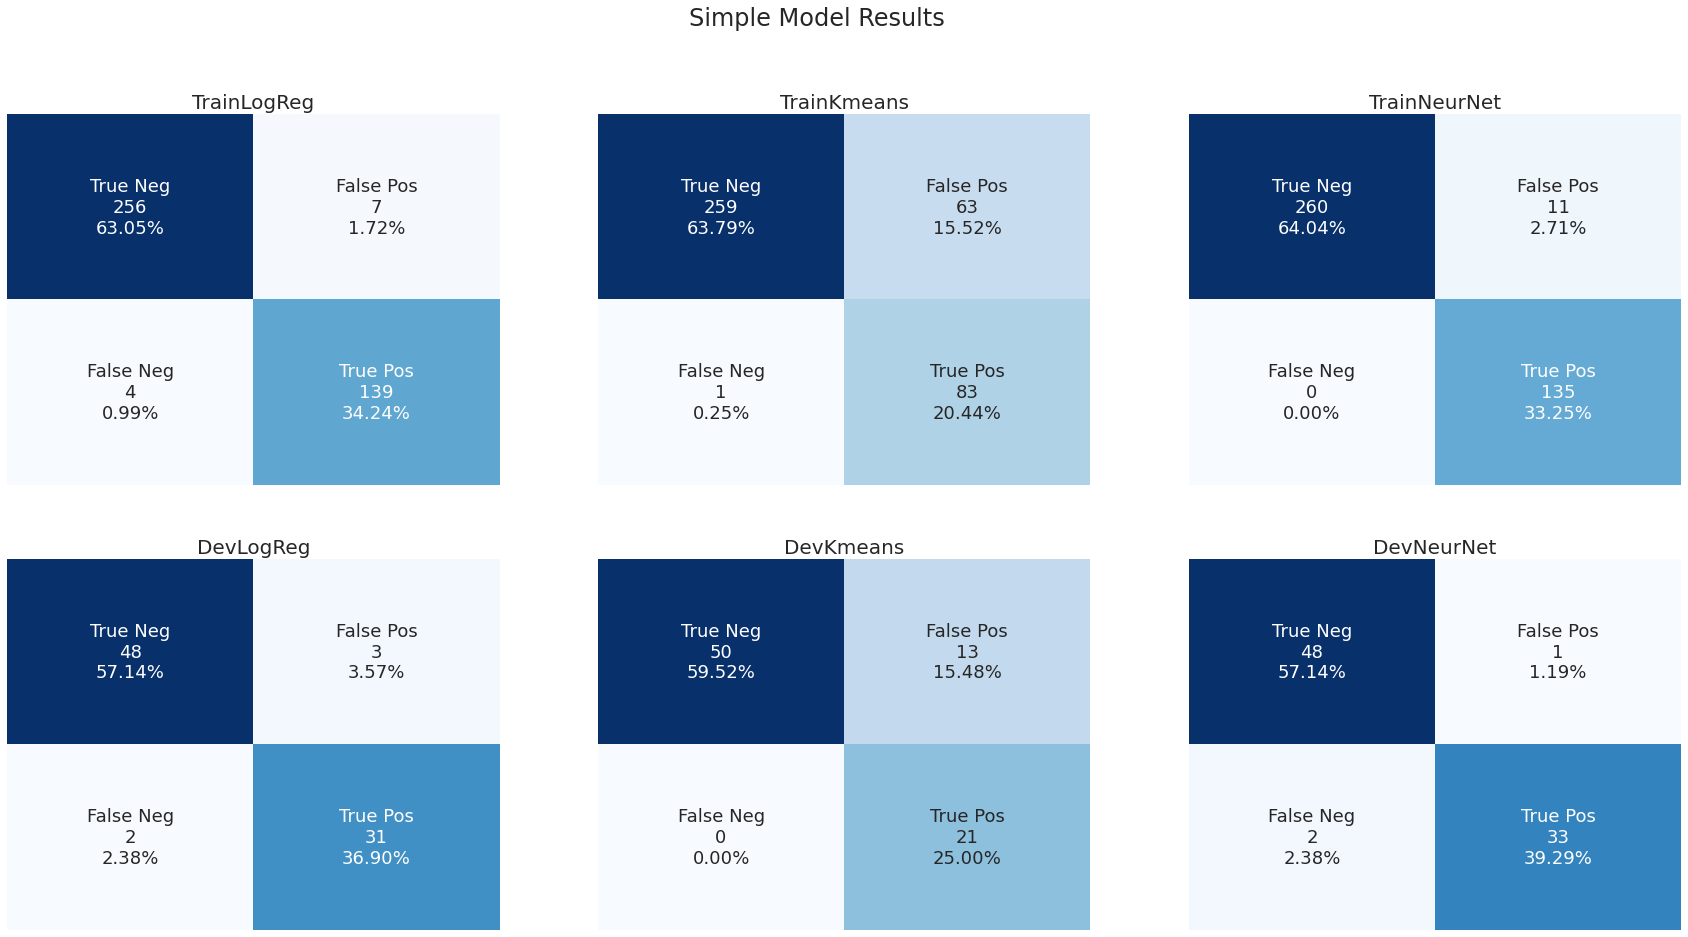

In [165]:
# plot the confusion matrices
fig, ax = plt.subplots(2, 3, figsize=(15, 30))
fig.set_figwidth(30)
fig.set_figheight(15)
sns.set(font_scale=1.5)
fig.suptitle('Simple Model Results',fontsize = 24)
cur_col = 0
for i, key in enumerate(CMs.keys()):
    cm = CMs[key]
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    if 'Dev' in key:
        sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', ax=ax[1,cur_col], cbar=False, xticklabels=False, yticklabels=False)
        ax[1,cur_col].set_title(key, fontsize=20)
        cur_col += 1
    else:
        sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', ax=ax[0,cur_col], cbar=False, xticklabels=False, yticklabels=False)
        ax[0,cur_col].set_title(key, fontsize=20)
        
# fig.savefig(simpleModelResultsCMsName)

## Summary:
+ Logit Regression had best overall performance
+ KMeans had worst performance
+ Neural Net was ok, but not as good as the Logit Regression

# Goal:
+ Reduce the occurance of False Negatives to 0%


The primary goal is to build a model that gives ZERO false negative predictions.  
We wish to avoid telling someone they do not have cancer, when in fact they do.  
Consequently, all efforts will be focused on reducing this particular error rate.
We are ok with a higher false positive rate.

## Steps:
1. Reduce the dimensionality of the data
2. Divide data into clusters
3. Build a model on each cluster

### Step 1: Reduct Dimensionality of the Data
Trying to visualize data in 30 dimensions is hard.   
We will try to reduce the dimensions down to 2.    
The hope is that the new projection can be easily split into 2 groups.    

There are two reduction techniques that we will explore: 
+ TSNE
+ UMAP   

Depending on how the projections of each looks, we will select 1 model to proceed with.

In [166]:
# fitting TSNE
tsne = TSNE()
tsnefit = tsne.fit_transform(xTrain)
tsneResults = pd.DataFrame()
tsneResults['diagnosis'] = trainDf['diagnosis']
tsneResults['x'] = tsnefit[...,0]
tsneResults['y'] = tsnefit[...,1]
# we add the max of x and y to each variable, in order to shift it away from negative number territory. 
# we don't like dealing with negative numbers
tsneResults['x'] = tsneResults['x'] + tsneResults['x'].max()
tsneResults['y'] = tsneResults['y'] + tsneResults['y'].max()

In [167]:
# fitting UMAP
umap  = UMAP()
umapfit = umap.fit_transform(xTrain)
umapResults = pd.DataFrame()
umapResults['diagnosis'] = trainDf['diagnosis']
umapResults['x'] = umapfit[...,0]
umapResults['y'] = umapfit[...,1]
umapResults['x'] = umapResults['x'] + umapResults['x'].max()
umapResults['y'] = umapResults['y'] + umapResults['y'].max()

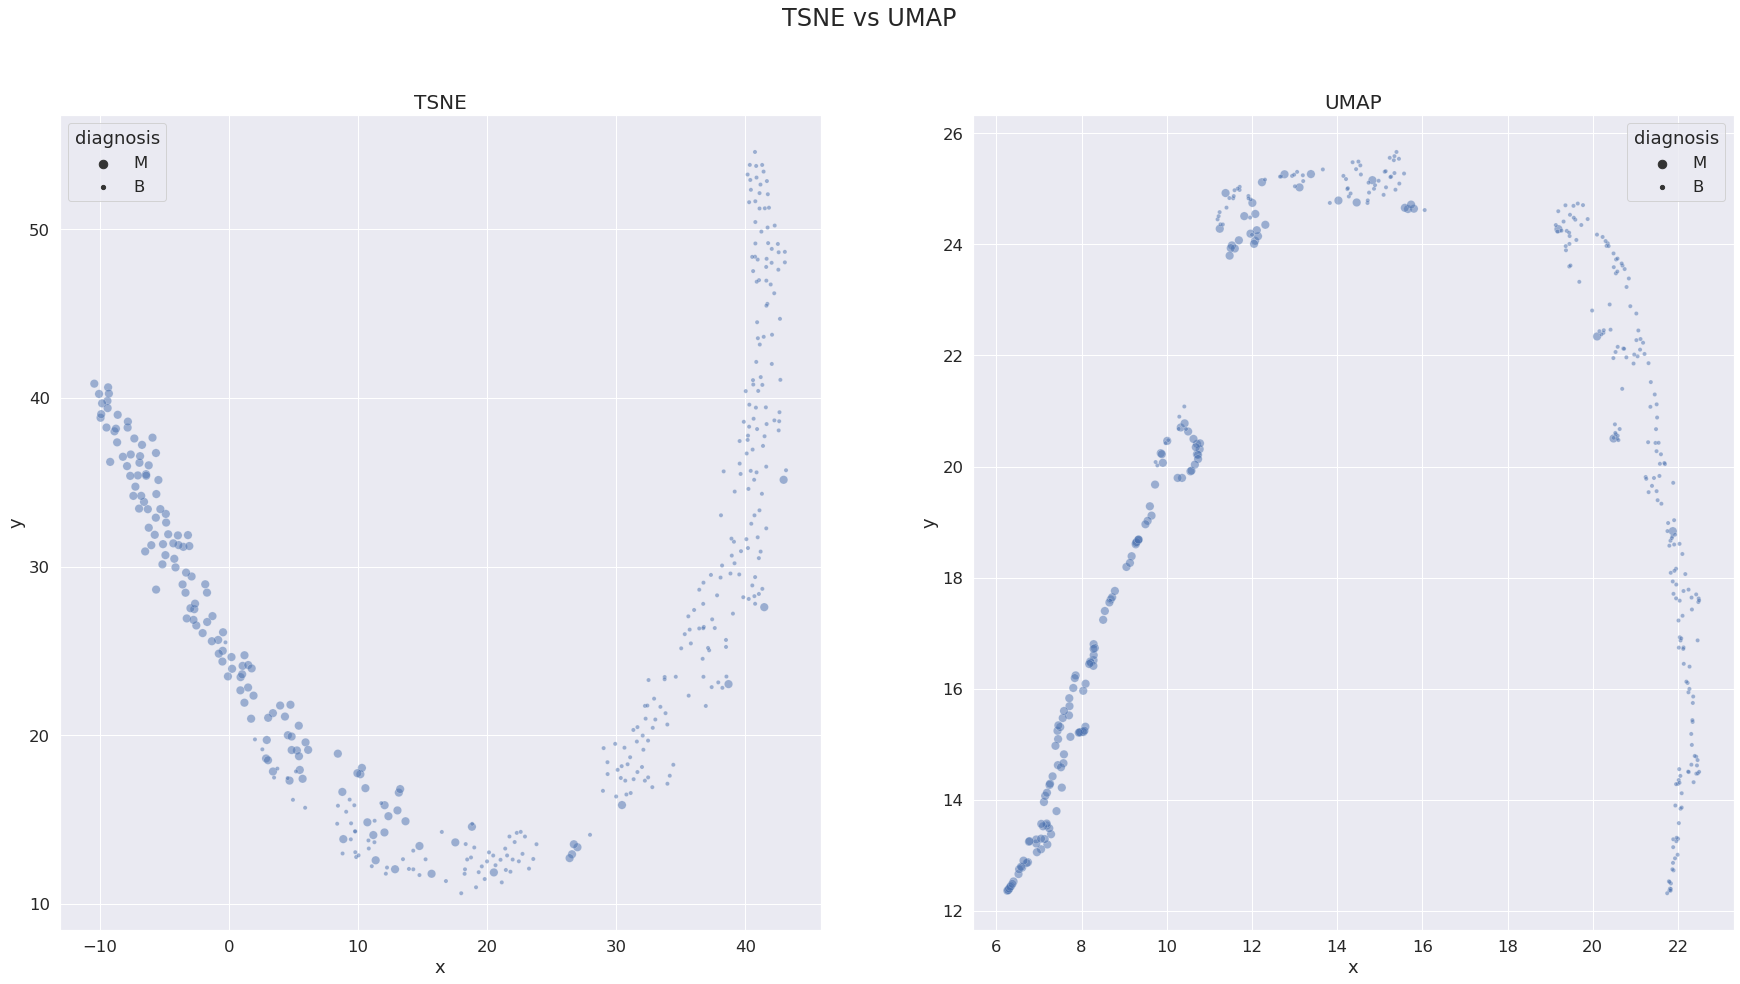

In [168]:
fig, ax = plt.subplots(1, 2, figsize=(15, 30))
fig.set_figwidth(30)
fig.set_figheight(15)
sns.set(font_scale=1.5)
fig.suptitle('TSNE vs UMAP',fontsize = 24)

sns.scatterplot(x='x', y='y', size='diagnosis', alpha=0.5, data=tsneResults, ax=ax[0])
ax[0].set_title("TSNE", fontsize=20)
sns.scatterplot(x='x', y='y', size='diagnosis', data=umapResults, alpha=0.5, ax=ax[1])
ax[1].set_title("UMAP", fontsize=20)
# fig.savefig(TSNEvsUMAPImageName)

### Step 1.5: Find Optimal UMAP Parameters

We think the UMAP reduction shows a much clearer distinction between groups.  
Therefore, we shall proceed with UMAP. 

### Step 2: Divide Data into Clusters
Next, we will build a KMeans model on the reduced UMAP output, to see if the model provides good deliniation. 

In [266]:
# build the KMeans model on the UMAP output
ensembleKmeans = KMeans(n_clusters=2)
ensembleKmeans.fit(umapResults[['x','y']])

KMeans(n_clusters=2)

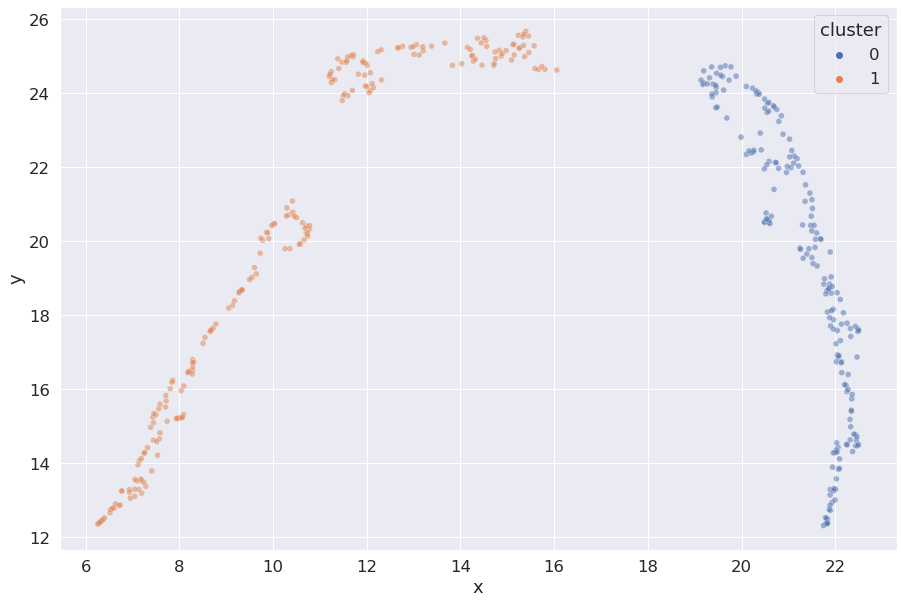

In [267]:
# predict clusters on the UMAP results
clusteredUMAP = umapResults[['x','y']].copy()
clusteredUMAP['cluster'] = ensembleKmeans.predict(umapResults[['x','y']])
# plot the clustered UMAP results
sns.scatterplot(x='x', y='y', hue='cluster', data=clusteredUMAP, alpha=.5)
# plt.savefig(clusteredUMAPImageName)

### Step 3: Build a model on each cluster

In [2]:
neurNetParams = {'learning_rate': 0.0001, 'loss': kr.losses.BinaryCrossentropy(), 'activation': tf.nn.swish, 'metrics': ['Recall']}
ensembleNeurNetClusters = trainNeurNetOnClusts2(umapResults[['x','y']], ensembleKmeans, xTrain, yTrain, neurNetParams)

Text(0.5, 61.5, 'Predicted Label')

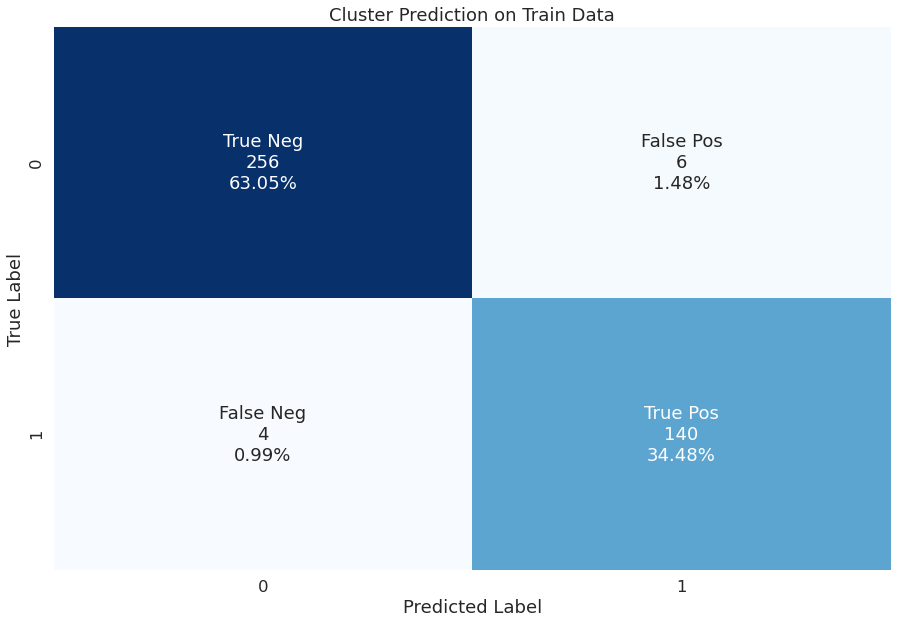

In [283]:
# calculate the predictions and confusion matrix on the Dev set, using our ensemble

trainInput = trainDf.copy().drop(['diagnosis'], axis=1).values
trainPredicts = np.array([ makePred2(x, ensembleNeurNetUMAP, ensembleKmeans, ensembleNeurNetClusters, y) for x, y in zip(trainInput, umapResults[['x','y']].values)])
trainPredicts = np.round(trainPredicts)
trainCM = confusion_matrix(yTrain, trainPredicts)
# plot the confusion matrix
cm = trainCM
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False)
plt.title("Cluster Prediction on Train Data")
plt.ylabel("True Label") 
plt.xlabel("Predicted Label") 

### Step 2.5: Train Neural Network for Dimensionality Reduction
Because UMAP (and TSNE) both use a stochastic method for reducting dimensions, there is no way to "train" a UMAP make "predictions" for new data.   
This is a problem for us because we are relying on this mapping for clustering.   
To work around this, we will train a neural network to try to mimic this particular mapping:
1. Split Train data into 3 parts: subTrain, subDev, and subTest.
2. Build a neural network on the subTrain set, using the 30 original factors as inputs, and the 2 UMAP variables as targets. 
3. Validate the neural network predictions will result in the same cluster membership as determined by the KMeans model. 
4. Once tested and validated, train the neural network on the entire Test set. 

Because we ultimately want to predict correct cluster membership, we want to choose a Loss function that is resistant to outliers.  
The Huber Loss function sounds promising. We will compare the Huber Loss function,  with other loss functions, like MSLE, and MAPE.

First we will sub-split the Training data

In [171]:
# sub-split the Train data, into another Train, Dev, Test set
trainDfL2, devDfL2, testDfL2 =  subSplitTrainData(trainDf, clusteredUMAP)

In [172]:
# create training and testing objects
xTrainL2 = trainDfL2.copy().drop(['diagnosis','x','y','cluster'], axis = 1)
yTrainL2 = trainDfL2[['x', 'y']].copy()
yTrainCluster = trainDfL2['cluster'].copy()
xDevL2 = devDfL2.copy().drop(['diagnosis','x','y','cluster'], axis = 1)
yDevL2 = devDfL2[['x', 'y']].copy()
yDevCluster = devDfL2['cluster'].copy()

xTestL2 = testDfL2.copy().drop(['diagnosis','x','y','cluster'], axis = 1)
yTestL2 = testDfL2[['x', 'y']].copy()
yTestCluster = testDfL2['cluster'].copy()

Next, we create a list of Neural Network parameters, and train a NN on each

In [173]:
# create a list of parameters to train Neural Networks with.
paramMap = {'learning_rate': [ 0.0001],
                  'loss': ['MSLE', 'MAPE', 'Huber'],
                  'activation': [tf.nn.swish]}
neurNetParamsList = paramMapToParamList(paramMap)
neurNetParamsList

[{'learning_rate': 0.0001,
  'loss': 'MSLE',
  'activation': <tensorflow.python.ops.custom_gradient.Bind at 0x7fa8afd679a0>},
 {'learning_rate': 0.0001,
  'loss': 'MAPE',
  'activation': <tensorflow.python.ops.custom_gradient.Bind at 0x7fa8afd679a0>},
 {'learning_rate': 0.0001,
  'loss': 'Huber',
  'activation': <tensorflow.python.ops.custom_gradient.Bind at 0x7fa8afd679a0>}]

In [3]:
# train a NN on each parameter set
trainingSubNeurNetModels = []
for i, paramSet in enumerate(neurNetParamsList):
    tempModel = trainNeurNetModelBigBatch(xTrainL2.values, yTrainL2.values, paramSet)
    trainingSubNeurNetModels.append(tempModel)

Next, we predict the UMAP Results for the Training and Dev Sets with each of the trained Neural Networks

In [175]:
# get the predictions for each model, on the trainingL2 set
trainPredictions = []
for i, thisModel in enumerate(trainingSubNeurNetModels):
    tempPreds = thisModel.predict(xTrainL2.values)
    trainPredictions.append(tempPreds)

In [176]:
# get the predictions for each model, on the devL2 set
devPredictions = []
for i, thisModel in enumerate(trainingSubNeurNetModels):
    tempPreds = thisModel.predict(xDevL2.values)
    devPredictions.append(tempPreds)

Now we will plot the Neural Network predictions vs Actual UMAP Results

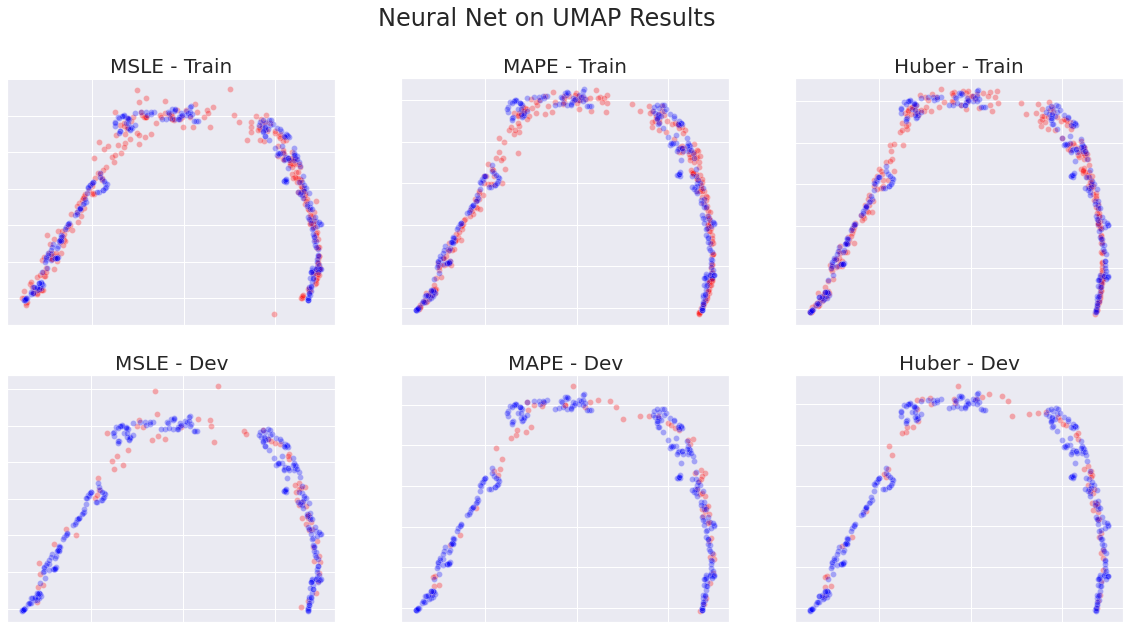

In [177]:
# plot the neural network predictions against the actuals for the trainingL2 and devL2 sets
fig, ax = plt.subplots(2, 3, figsize=(30, 60))
fig.set_figwidth(20)
fig.set_figheight(10)
sns.set(font_scale=1.5)
fig.suptitle('Neural Net on UMAP Results',fontsize = 24)
for i, curParam in enumerate(neurNetParamsList):
    curLoss = curParam['loss']
    sns.scatterplot(x=trainPredictions[i][:,0], y=trainPredictions[i][:,1], alpha=0.3, color='red', ax=ax[0,i])
    sns.scatterplot(x='x', y='y', data=yTrainL2, alpha=0.3, color='blue', ax=ax[0,i])
    ax[0,i].set_title(curLoss + ' - Train', fontsize=20)
    ax[0,i].set(xticklabels=[])
    ax[0,i].set(yticklabels=[])
    ax[0,i].set_ylabel('')    
    ax[0,i].set_xlabel('')
    sns.scatterplot(x=devPredictions[i][:,0], y=devPredictions[i][:,1], alpha=0.3, color='red', ax=ax[1,i])
    sns.scatterplot(x='x', y='y', data=yTrainL2, alpha=0.3, color='blue', ax=ax[1,i])
    ax[1,i].set_title(curLoss + ' - Dev', fontsize=20)
    ax[1,i].set(xticklabels=[])
    ax[1,i].set(yticklabels=[])
    ax[1,i].set_ylabel('')    
    ax[1,i].set_xlabel('')
    
# fig.savefig(neurNetParamCompareImageName)

As expected, the Huber Loss function gives the clearest delineation. 

The final test is to make sure the Huber Loss fuction does not give an estimate that results in an incorrect cluster assignment

In [178]:
# get the predictions for each cluster membership, on the trainingL2 set
trainPredClusters = []
for i, thisModel in enumerate(trainPredictions):
    tempClustPreds = ensembleKmeans.predict(thisModel)
    trainPredClusters.append(tempClustPreds)

In [179]:
# get the predictions for each cluster membership, on the devL2 set
devPredClusters = []
for i, thisModel in enumerate(devPredictions):
    tempClustPreds = ensembleKmeans.predict(thisModel)
    devPredClusters.append(tempClustPreds)

In [180]:
# checking cluster predictions on the devL2 data
for i, thisModel in enumerate(devPredClusters):
    isSame = yDevCluster == thisModel
    totalSame = np.sum(isSame)
    curLoss = neurNetParamsList[i]['loss']
    print("the KMeans model was able to predict {} correct memberships with the {} loss function on the Dev set".format(totalSame, curLoss))
print("Total observations in Dev set is: {}".format(len(isSame)))

the KMeans model was able to predict 66 correct memberships with the MSLE loss function on the Dev set
the KMeans model was able to predict 67 correct memberships with the MAPE loss function on the Dev set
the KMeans model was able to predict 67 correct memberships with the Huber loss function on the Dev set
Total observations in Dev set is: 70


In [181]:
# checking cluster predictions on the testL2 data
testPredictions = []
for i, thisModel in enumerate(trainingSubNeurNetModels):
    tempPreds = thisModel.predict(xTestL2.values)
    testPredictions.append(tempPreds)
testPredClusters = []
for i, thisModel in enumerate(testPredictions):
    tempClustPreds = ensembleKmeans.predict(thisModel)
    testPredClusters.append(tempClustPreds)
for i, thisModel in enumerate(testPredClusters):
    isSame = yTestCluster == thisModel
    totalSame = np.sum(isSame)
    curLoss = neurNetParamsList[i]['loss']
    print("the KMeans model was able to predict {} correct memberships with the {} loss function on the Test set".format(totalSame, curLoss))
print("Total observations in Test set is: {}".format(len(isSame)))

the KMeans model was able to predict 54 correct memberships with the MSLE loss function on the Test set
the KMeans model was able to predict 55 correct memberships with the MAPE loss function on the Test set
the KMeans model was able to predict 56 correct memberships with the Huber loss function on the Test set
Total observations in Test set is: 56


It appears that we can process with the Huber Loss function with confidence. 

The next step is to train a Neural Net with the selected parameters on the whole Training set

In [4]:
neurNetUMAPParams = {'learning_rate': 0.0001, 'loss': 'Huber', 'activation': tf.nn.swish}
ensembleNeurNetUMAP = trainNeurNetModel(xTrain, umapResults[['x','y']], neurNetParams=neurNetUMAPParams)

### Predictions and Results
First, we'll do a prediction on the Dev data set to see if everything looks good

In [201]:
# calculate the predictions and confusion matrix on the Dev set, using our ensemble
devInput = devDf.copy().drop(['diagnosis'], axis=1).values
devPredicts = np.array([ makePred(x, ensembleNeurNetUMAP, ensembleKmeans, ensembleNeurNetClusters) for x in devInput])
devPredicts = np.round(devPredicts)
devCM = confusion_matrix(yDev, devPredicts)


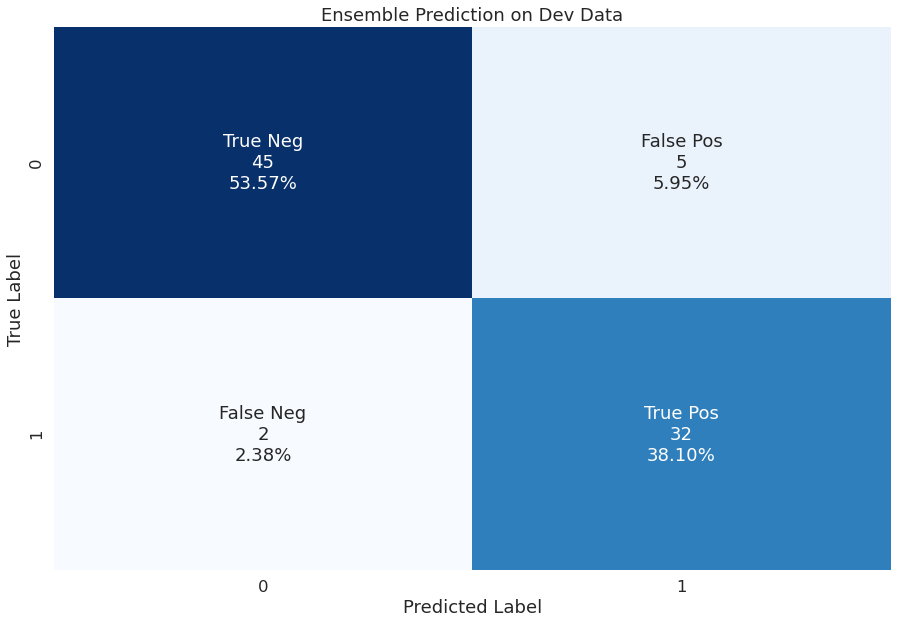

In [202]:
# plot the confusion matrix
cm = devCM
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False)
plt.title("Ensemble Prediction on Dev Data")
plt.ylabel("True Label") 
plt.xlabel("Predicted Label") 
# plt.savefig(ensembleDevResultsImageName)

These results look very promising! Lets go ahead and run the model on the Test data set, and see how it compares to the Logistic Regressin Model

In [203]:
# converting the test data into inputs and outputs
xTest = testDf.copy().drop(['diagnosis'], axis = 1)
yTest = testDf.copy()['diagnosis']
yTest.iloc[:] = lblEnc.transform(yTest)

In [204]:
# using the ensemble model to make predictions, and calculate the confusion matrix
testInput = testDf.copy().drop(['diagnosis'], axis=1).values
testPredicts = [ makePred(x, ensembleNeurNetUMAP, ensembleKmeans, ensembleNeurNetClusters) for x in testInput]
testCM = confusion_matrix(yTest, np.round(testPredicts))

In [205]:
# using the Logit Reg model to make predictions, and calculate the confusion matrix
testLogRegPred = simpleLogReg.predict(xTest)
testLogRegCM = confusion_matrix(yTest, testLogRegPred)

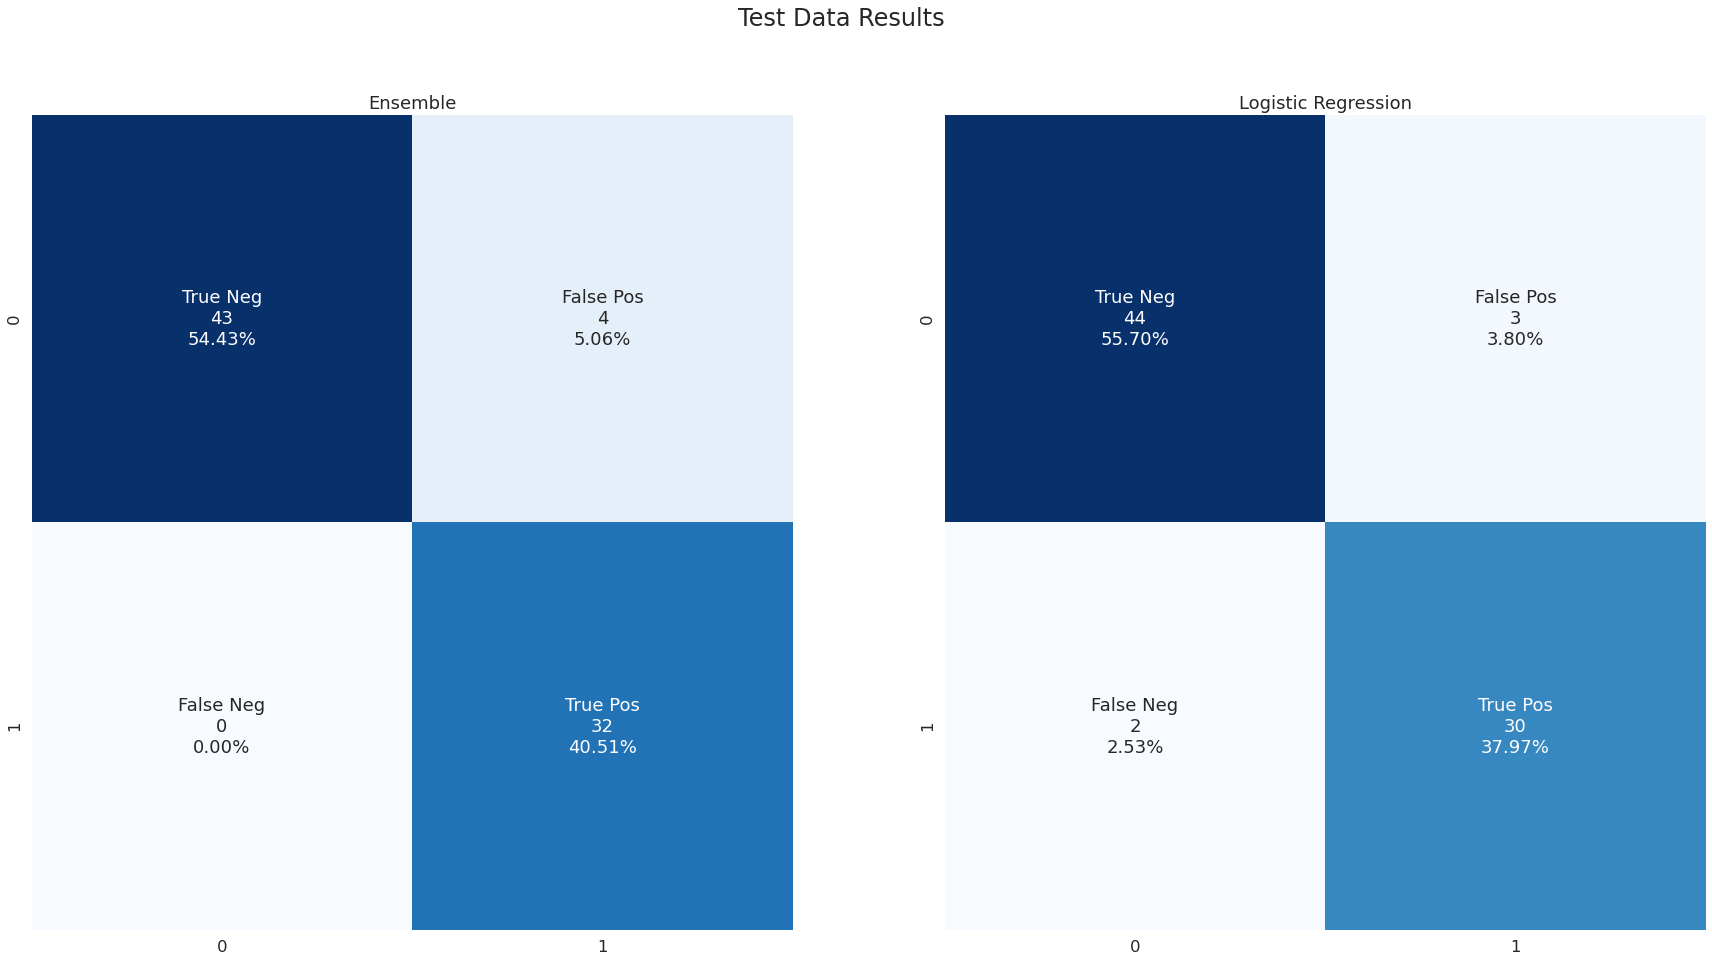

In [206]:
# plotting the confusion matrices of the ensemble vs logit reg
fig, ax = plt.subplots(1, 2, figsize=(15, 30))
fig.set_figwidth(30)
fig.set_figheight(15)
sns.set(font_scale=1.5)
fig.suptitle('Test Data Results',fontsize = 24)

cm = testCM
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False, ax=ax[0])
ax[0].set_title("Ensemble")

cm = testLogRegCM
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False, ax=ax[1])
ax[1].set_title("Logistic Regression")

# fig.savefig(ensembleVsLogRegTestResultsImageName)

# Conclusion:
We have sucessfully built a model with a lower false negative rate than our best model!

I wouldn't trust this model though. 
We had less than 600 observations, which isn't much at all. 
I would to attempt this on lots more data before I could be confident in int.